In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz",
                                url,
                                untar=True,
                                cache_dir='.',
                                cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')


84131840/84125825 [==============================] - 10s 0us/step


In [3]:
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

In [4]:
from glob import glob
files_dir = os.path.join(train_dir, 'neg/*.txt')
files = glob(files_dir)
with open(files[0]) as f:
    print(f.read())


Not the best of the films to be watched nowadays. I read a lot of reviews about Shining and was expecting it to be very good. But this movie disappointed me. The sound and environment was good, but there was no story here. Not was there a single moment of fright. I expected it to a horror thriller movie, but there was no horror no thriller. The only scene where I got scared was during the chapter change scene showing "Wednesday". There are lots of fragments i the movie. Most of the things are left unexplained with nothing to link it to anything. The story does not tell us about the women or other scenes that is shown. Might be a good movie to watch in the 80's, but not for the 21st century.


In [5]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [6]:
batch_size = 256
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    './aclImdb/train', 
    label_mode='categorical',
    batch_size=batch_size, 
    validation_split=0.20, 
    subset='training', 
    seed=seed)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [7]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    './aclImdb/train', 
    label_mode='categorical',
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [8]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)
raw_test_ds

Found 25000 files belonging to 2 classes.


<BatchDataset shapes: ((None,), (None,)), types: (tf.string, tf.int32)>

In [9]:
for text_batch, label_batch in raw_train_ds.take(1):
    print("Crítica:") 
    print(text_batch.numpy()[0],'\n')
    print("Etiqueta:", label_batch.numpy()[0])

Crítica:
b'Example of how a World War 2 documentary should be made,using first hand accounts from actual troops and civilians whom participated in this awful conflict,and archived footage gathered from around the time .I caught this on a re-run on the History channel about a year and a half back,with no knowledge really of the Second World War at the time,but it enveloped me,and now I consider myself a World War 2 buff,watching and reading any and all that I can find about it,but nothing comes close to this landmark documentary,definitely worth buying the boxed set of.............<br /><br />This is quite simply documentary making of the very highest standard.' 

Etiqueta: [0. 1.]


In [10]:
def normalizacion(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')


In [11]:
'[%s]' % re.escape(string.punctuation)

'[!"\\#\\$%\\&\'\\(\\)\\*\\+,\\-\\./:;<=>\\?@\\[\\\\\\]\\^_`\\{\\|\\}\\~]'

In [12]:
normalizacion(text_batch.numpy()[0])

<tf.Tensor: shape=(), dtype=string, numpy=b'example of how a world war 2 documentary should be madeusing first hand accounts from actual troops and civilians whom participated in this awful conflictand archived footage gathered from around the time i caught this on a rerun on the history channel about a year and a half backwith no knowledge really of the second world war at the timebut it enveloped meand now i consider myself a world war 2 buffwatching and reading any and all that i can find about itbut nothing comes close to this landmark documentarydefinitely worth buying the boxed set of  this is quite simply documentary making of the very highest standard'>

In [13]:
vocabulario = 10000
largo_maximo = 150

capa_vectorizacion = TextVectorization(
                            standardize=normalizacion,
                            max_tokens=vocabulario,
                            output_mode='int',
                            output_sequence_length=largo_maximo)


In [14]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
capa_vectorizacion.adapt(train_text)


In [15]:
def vectorizar_texto(text, label):
    text = tf.expand_dims(text, -1)
    return capa_vectorizacion(text), label

In [16]:
train_ds = raw_train_ds.map(vectorizar_texto)
val_ds = raw_val_ds.map(vectorizar_texto)
test_ds = raw_test_ds.map(vectorizar_texto)


In [17]:
for text_batch, label_batch in train_ds.take(1):
    print("Crítica:") 
    print(text_batch.numpy()[0],'\n')
    print("Etiqueta:", label_batch.numpy()[0])

Crítica:
[  10 1182   66   57  314   12    2 2809  199 7271   10 2294    2  172
   21    2 1946    1   13  125 5700    8    2  858   10  204    1    2
 6223 2859 3493    5    2 5414 3163   14   24  229 4831 8152    8    2
  191  503   18   12   13  153   54 1678  112  947 5236  718   33 2216
    3 9583 1897 1004    5    2  574    4  471 3802    3    1    5    1
   12  157  696   44    4   50   41  322 2015  839   48  501   44   14
    4 1500 3036  795    5  538  447 2072  519  294    4  685  459   51
    4    1    5  336    1 4988  456 9204    6 1006  257    1    1    3
 6088 2723    4  247    8    2  468 5122   15   22   67   11  804  247
    7    2 9017    5 2215    1   36   13    4    1    1  437  247    8
    1    3    1 3420  126 2176   79    5    1 6358] 

Etiqueta: [1. 0.]


In [18]:
train_ds = train_ds.cache().prefetch(buffer_size=1)
val_ds = val_ds.cache().prefetch(buffer_size=1)
test_ds = test_ds.cache().prefetch(buffer_size=1)

In [19]:
train_ds

<PrefetchDataset shapes: ((None, 150), (None, 2)), types: (tf.int64, tf.float32)>

In [20]:
embedding_dim = 16
estado_oculto = 32

tf.keras.backend.clear_session()

inputs = tf.keras.layers.Input([largo_maximo])

layer_1 = tf.keras.layers.Embedding(vocabulario + 1, embedding_dim, mask_zero=True)
out_1 = layer_1(inputs)

layer_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(estado_oculto))
out_2 = layer_2(out_1)

layer_3 = tf.keras.layers.Dense(50, activation='relu')
out_3 = layer_3(out_2)

layer_4 = tf.keras.layers.Dropout(0.2)
out_4 = layer_4(out_3)

layer_5 = tf.keras.layers.Dense(2, activation='softmax')
out_5 = layer_5(out_4)

model = tf.keras.models.Model(inputs=inputs, outputs=out_5)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 16)           160016    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 50)                3250      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102       
Total params: 175,912
Trainable params: 175,912
Non-trainable params: 0
________________________________________________

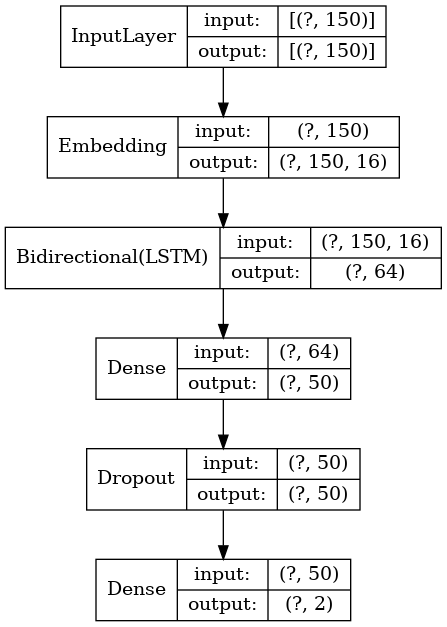

In [21]:
model.summary()
tf.keras.utils.plot_model(    model, show_layer_names=False, show_shapes=True)

In [22]:

metrics = [tf.keras.metrics.Recall()]

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=metrics,
             optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), )

In [23]:
epochs = 10
history = model.fit(x=train_ds,
                    validation_data=val_ds,
                    validation_freq=1,
                    epochs=epochs)


Epoch 1/10
79/79 [==============================] - 11s 144ms/step - loss: 0.6312 - recall: 0.6399 - val_loss: 0.5026 - val_recall: 0.8076
Epoch 2/10
79/79 [==============================] - 8s 104ms/step - loss: 0.4733 - recall: 0.8398 - val_loss: 0.4893 - val_recall: 0.8270
Epoch 3/10
79/79 [==============================] - 8s 107ms/step - loss: 0.4353 - recall: 0.8762 - val_loss: 0.4613 - val_recall: 0.8432
Epoch 4/10
79/79 [==============================] - 9s 109ms/step - loss: 0.4121 - recall: 0.8989 - val_loss: 0.4620 - val_recall: 0.8400
Epoch 5/10
79/79 [==============================] - 9s 109ms/step - loss: 0.3960 - recall: 0.9168 - val_loss: 0.4859 - val_recall: 0.8198
Epoch 6/10
79/79 [==============================] - 9s 113ms/step - loss: 0.4079 - recall: 0.9031 - val_loss: 0.4606 - val_recall: 0.8464
Epoch 7/10
79/79 [==============================] - 10s 127ms/step - loss: 0.3916 - recall: 0.9199 - val_loss: 0.4616 - val_recall: 0.8438
Epoch 8/10
79/79 [==============

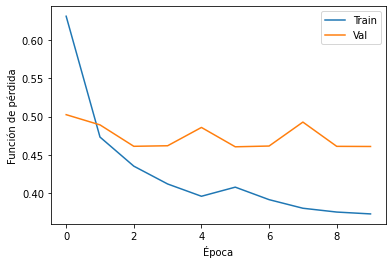

In [24]:
plt.plot(np.arange(epochs), history.history['loss'], label='Train')
plt.plot(np.arange(epochs), history.history['val_loss'], label='Val')
plt.legend(loc=0)
plt.xlabel('Época')
plt.ylabel('Función de pérdida')
plt.show()

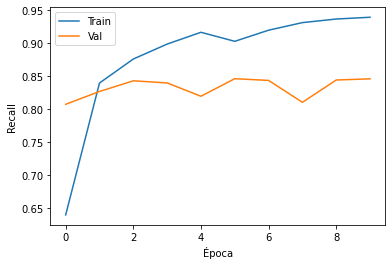

In [25]:
plt.plot(np.arange(epochs), history.history['recall'], label='Train')
plt.plot(np.arange(epochs), history.history['val_recall'], label='Val')
plt.legend(loc=0)
plt.xlabel('Época')
plt.ylabel('Recall')
plt.show()